In [27]:
import os

import numpy as np
import pandas as pd
from math import erfc, sqrt
from scipy import stats
import statsmodels.api as sm
import scipy.optimize as opt
import matplotlib.pyplot as plt
import warnings

from utils import rouwenhorst
from src.mehra_economy import MehraEconomy
from src.calibrate_mc_from_data import CalibrateMcChainFromData
from src.markov_chain import MarkovChain

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In this notebook, the goal is to replicate asset pricing from observed consumption growth.
This is done using the Mehra-Prescott model from 1985, which is based on a Lucas tree economy.

## Summary statistics of monthly, annual and quarterly growth

In [28]:
df_month = pd.read_csv("./data/PCE monthly growth data.csv", index_col='date')  # Monthly data
df_quart = pd.read_csv("./data/PCE quarterly growth data.csv", index_col='date')
df_annual = pd.read_excel("./data/PCE growth data.xlsx", index_col='year')

def describe(df, stats):
    d = df.describe()
    return d.append(df.reindex(d.columns, axis = 1).agg(stats))

out = pd.DataFrame()
out1 = {}

for df, name in zip([df_month, df_quart, df_annual], ['Monthly', 'Quarterly', 'Annual']):
    out[name] = describe(df, ['skew', 'kurt'])

    out1[name] = []
    for i in [1,2,3]:
        out1[name].append(df['growth'].autocorr(lag=i))

out1 = pd.DataFrame(out1, index=['AR(1)', 'AR(2)', 'AR(3)'])

out.append(out1).round(4)

,Monthly,Quarterly,Annual
count,743.0000,295.0000,91.0000
mean,0.0015,0.0045,0.0173
std,0.0071,0.0094,0.0220
min,-0.1331,-0.1109,-0.0806
25%,-0.0007,0.0020,0.0099
50%,0.0016,0.0047,0.0203
75%,0.0038,0.0075,0.0305
max,0.0624,0.0751,0.0737
skew,-8.4756,-5.0063,-1.5460
kurt,186.7268,88.6626,5.1247


Lower frequency data (annual) is more persistent than higher frequency data as can be seen by their AR(1) components. Since in the Mehra-Prescott model, $p=\frac{1+\rho}{2}$, then it follows that for $\rho$ close to zero, $p$ will be very close to $0.5$. Thus, for annual data, we can infer that $p>>0.5$ and thus persistence of a Markov Chain will be higher. As a result, all else equal, higher persistence decreases the equity premium in the Mehra-Prescott model. Thus, using the annual data, we expect to find a smaller premium than we would have for monthly data.

In [29]:
path_mehra = "./data/Shiller data extended.xlsx"
out, summ = run(n=2, path=path_mehra)

summ

NameError: name 'run' is not defined

### 10-state Markov Chain

In [30]:
out, summ = run(n=10, path=path_mehra)

summ

NameError: name 'run' is not defined

The 10-state chain appear to match the autocorrelation worse than the two-state, which is exact.

In [17]:
path_nipa = "./data/PCE growth data.xlsx"
out, summ = run(n=2, path=path_nipa)

summ

,Mean,Rho,Std
AR coef,0.009307,0.4795,0.018700
AR moments,1.017882,0.4795,0.021309
Markov Chain,1.017882,0.4795,0.021309


### 10-state chain

In [18]:
_, summ = run(n=10, path=path_nipa)

summ

,Mean,Rho,Std
AR coef,0.009307,0.479500,0.018700
AR moments,1.017882,0.479500,0.021309
Markov Chain,1.017882,0.919996,0.021309


In [19]:
_, summ = run(n=2, path=path_nipa, start_year=1950)
summ

,Mean,Rho,Std
AR coef,0.008654,0.493172,0.013500
AR moments,1.017075,0.493172,0.015519
Markov Chain,1.017075,0.493172,0.015519


### 10-state chain

In [20]:
_, summ = run(n=10, path=path_nipa, start_year=1950)
summ

,Mean,Rho,Std
AR coef,0.008654,0.493172,0.013500
AR moments,1.017075,0.493172,0.015519
Markov Chain,1.017075,0.971377,0.015519


## Calibrating a Markov Chain on annual data

In [31]:
# Calibrate a Markov chain on an AR(1) process on yearly growth
calibration = CalibrateMcChainFromData(df_annual)
mc = calibration(summary=True)  # Call method returns calibrated MarkovChain

                            OLS Regression Results                            
Dep. Variable:                 growth   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     25.27
Date:                Mon, 29 Nov 2021   Prob (F-statistic):           2.60e-06
Time:                        14:44:15   Log-Likelihood:                 231.44
No. Observations:                  90   AIC:                            -458.9
Df Residuals:                      88   BIC:                            -453.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0093      0.003      3.555      0.0

In [32]:
mc  # Resulting Markov Chain

Markov chain with transition matrix 
Pi = 
[[0.73975015 0.26024985]
 [0.26024985 0.73975015]]
 and state values = [0.99657272 1.03919074]
and stationary distribution = [0.5 0.5]

The unconditional mean of excess returns is practically zero. These findings do not confirm the empirically observed excess returns. It is puzzling that both risk-free returns and equity returns are both high at the same time. In the example, the risk-free rate is at 5\%, so in the data we should expect risk-free rates to be much higher. Thus, it is puzzling risk-free rates are so low empirically.

## Characterizing the Mehra-Prescott Economy from the Markov Chain

In [33]:
# Initialize economy object
beta = np.exp(-0.02)
gamma = 2.
econ = MehraEconomy(mc, beta=beta, gamma=gamma)
econ(beta, gamma)  # Run call method to generate asset prices and returns

econ.excess_ret_

0.00010089558890696848

In [34]:
[(key, econ.bonds.__dict__[key]) for key in econ.bonds.__dict__ if key in ['prices_', 'rets_', 'ret_']]

[('prices_', array([0.96631663, 0.92829637])),
 ('rets_', array([0.03485749, 0.07724217])),
 ('ret_', 0.056049830814633106)]

In [35]:
[(key, econ.stocks.__dict__[key]) for key in econ.stocks.__dict__ if key in ['prices_', 'rets_', 'ret_']]

[('prices_', array([27.09263073, 26.10059777])),
 ('rets_', array([0.03495448, 0.07734697])),
 ('ret_', 0.056150726403540074)]

Stock and bond returns are quite similar for these parameter values. Next we check if this is a general property of the model for many parameter combinations.

## Numerical experiment

In this section, we check the admissible region of excess returns for different pairs of ($\beta$, $\gamma$). Empirically, excess returns should be around 6\%, so we should expect the model to deliver such a return.

In [38]:
plt.rcParams.update({'font.size': 15})

def plot_economy(rf, re, ER, betas, gammas):
    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    #plt.tight_layout()
    fig.subplots_adjust(hspace=.4)

    axs[0, 0].scatter(rf, ER)
    axs[0, 1].scatter(betas, ER)
    axs[1, 0].scatter(gammas, rf, color='b', label='Risk-free')
    axs[1, 0].scatter(gammas, re, color='r', label='Stocks')
    axs[1, 0].legend()

    axs[1, 1].scatter(gammas, ER)

    for ax, xlab, ylab in zip(axs.flatten(), ['Rf', r'$\beta$', r'$\gamma$', r'$\gamma$'],
                              ['Excess Return', 'Excess Return', 'Return', 'Excess Return']):
        ax.set_xlabel(xlab)
        ax.set_title(ylab)

    plt.show()

### Admissible region of excess returns for differing paris ($\beta$, $\gamma$)

With the constraint that risk-free returns $\in (0, 0.04)$

The data is not able to reconstruct the empirical data. No combination of $\beta$ and $\gamma$ is able to match observed excess returns. Finally, the results here are quite different from those in the Mehra-Prescott paper, but this is due to them having a negative annual autocorrelation, whereas ours is positive. For a replication of their results see the final section. 

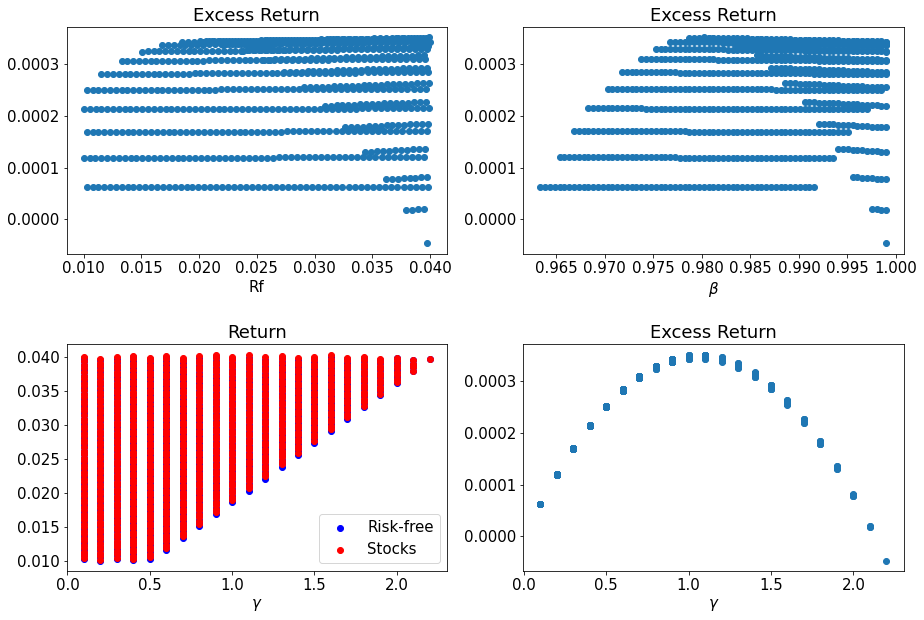

In [39]:
N = 100
ER, rf, re, betas, gammas = econ.num_experiment(N=N)
plot_economy(rf, re, ER, betas, gammas)

### Repeating above experiment, without the constraint that Rf<0.04

From the plot, it is evident that equity returns are increasing in $\gamma$, however so is the risk-free rate, which is even increasing faster than equity returns. Thus resulting in a negative excess return.

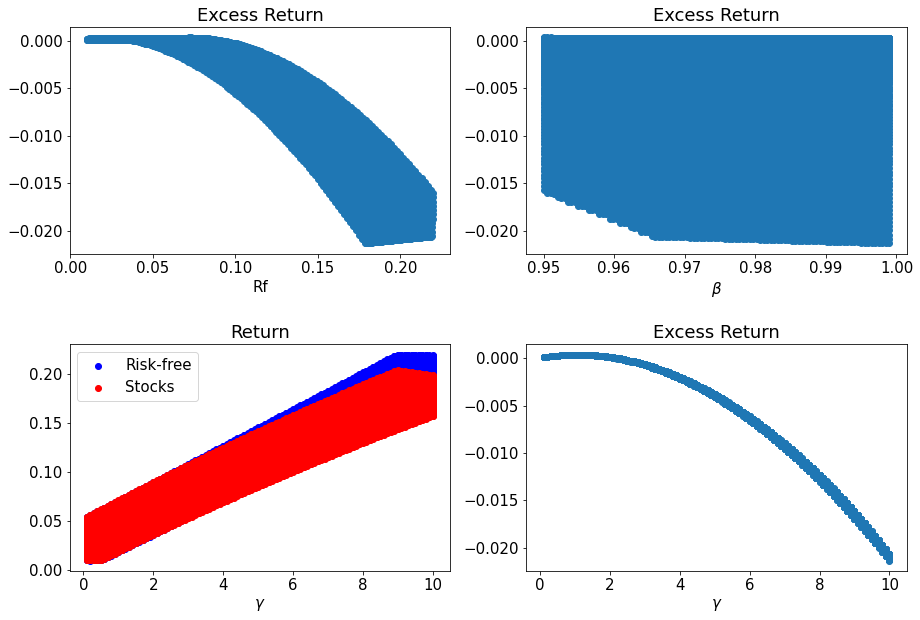

In [40]:
ER, rf, re, betas, gammas = econ.num_experiment(N=N, rf_bound=(0.01, 0.22))
plot_economy(rf, re, ER, betas, gammas)

## Appendix: Replicating Mehra-Prescotts Figure 4

To compare our results with the original ones, we here implement the model using the exact same numbers as used in the Mehra-Prescott paper. 

Upper left corner corresponds to their original figure 4. Interestingly, with their parameters the excess returns are now increasing in $\gamma$ and not decreasing. This is because, as mentioned, now the autocorrelation is negative. Yet, the model is still unable to capture empirical excess returns.

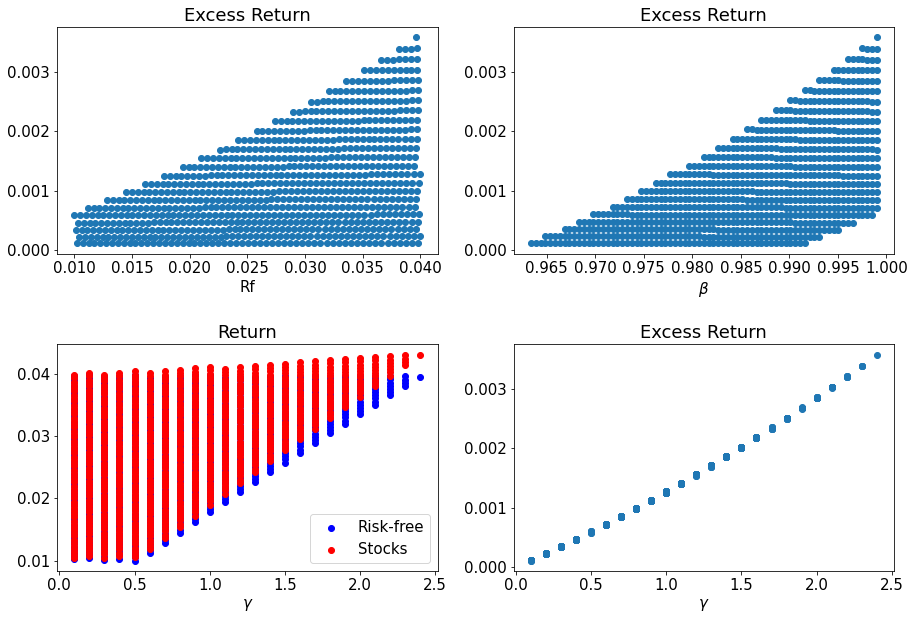

In [41]:
p = 0.43
x = np.array([ 1 +0.018 - 0.036, 1+ 0.018 + 0.036])
mc = MarkovChain(Pi=np.array([[p, 1 - p], [1 - p, p]]), x=x)

# Initialize economy object
econ = MehraEconomy(mc)
econ.calibrate_beta_to_rf(target_rf=0.05)

# Plot
ER, rf, re, betas, gammas = econ.num_experiment(N=N)
plot_economy(rf, re, ER, betas, gammas)